In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import cmocean

In [2]:
topo = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO5/dods')
topo = topo.rename({'X': 'lon', 'Y': 'lat','elev': 'z'})
topo['elev_ocean'] = topo.z.where(topo.z<0).load()
topo

<xarray.Dataset>
Dimensions:     (lat: 2160, lon: 4320)
Coordinates:
  * lon         (lon) float32 0.0 0.08333333 0.16666666 ... 359.8333 359.91666
  * lat         (lat) float32 90.0 89.916664 89.833336 ... -89.83333 -89.916664
Data variables:
    z           (lat, lon) int16 -4290 -4290 -4290 -4290 ... 2774 2774 2774 2774
    elev_ocean  (lat, lon) float64 -4.29e+03 -4.29e+03 -4.29e+03 ... nan nan nan
Attributes:
    Conventions:                 IRIDL
    dataset_documentation.html:  http://iridl.ldeo.columbia.edu/SOURCES/.NOAA...
    description:                 ETOPO5 5x5 minute land surface elevations an...

In [3]:
# Constants
R =  6371e3  # Mean radius of Earth [m]
AreaEarth = (4 * np.pi * R**2) # Surface area of idealized, spherical Earth [m^2]
AreaFootField = 5351.2 # Approximate area of a fotball field [m^2]
AreaUSA = 9834*1e9 # Approximate surface area of USA [m^2]

VolumeEarth = 4/3 * np.pi * R**3 # [m^3]

In [4]:
# How many USAs fit on Earth?
np.int(AreaEarth/AreaUSA)

51

In [5]:
# Calculate Earth's area from Etopo1 data
dlon = np.radians((topo['lon'][1]-topo['lon'][0]).values)
dlat = np.radians((topo['lat'][0]-topo['lat'][1]).values)
lat  = topo.lat

# Area elements
dA =  R**2 * dlon*dlat * np.cos(np.radians(lat))

# Check consistency with analytical result
topo['dA'] = dA * (0*topo.z + 1)
topo['AreaEarth'] = topo['dA'].sum()
AreaEarth/topo['AreaEarth'].values

# Ocean area
topo['AreaOcean'] = topo['dA'].where(topo['z']<0).sum()

In [6]:
# Fractional area covered by the world ocean
topo['AreaOcean'].values/topo['AreaEarth'].values

0.71393573

FileNotFoundError: [Errno 2] No such file or directory: 'assets/imgs/TopographyPDF.png'

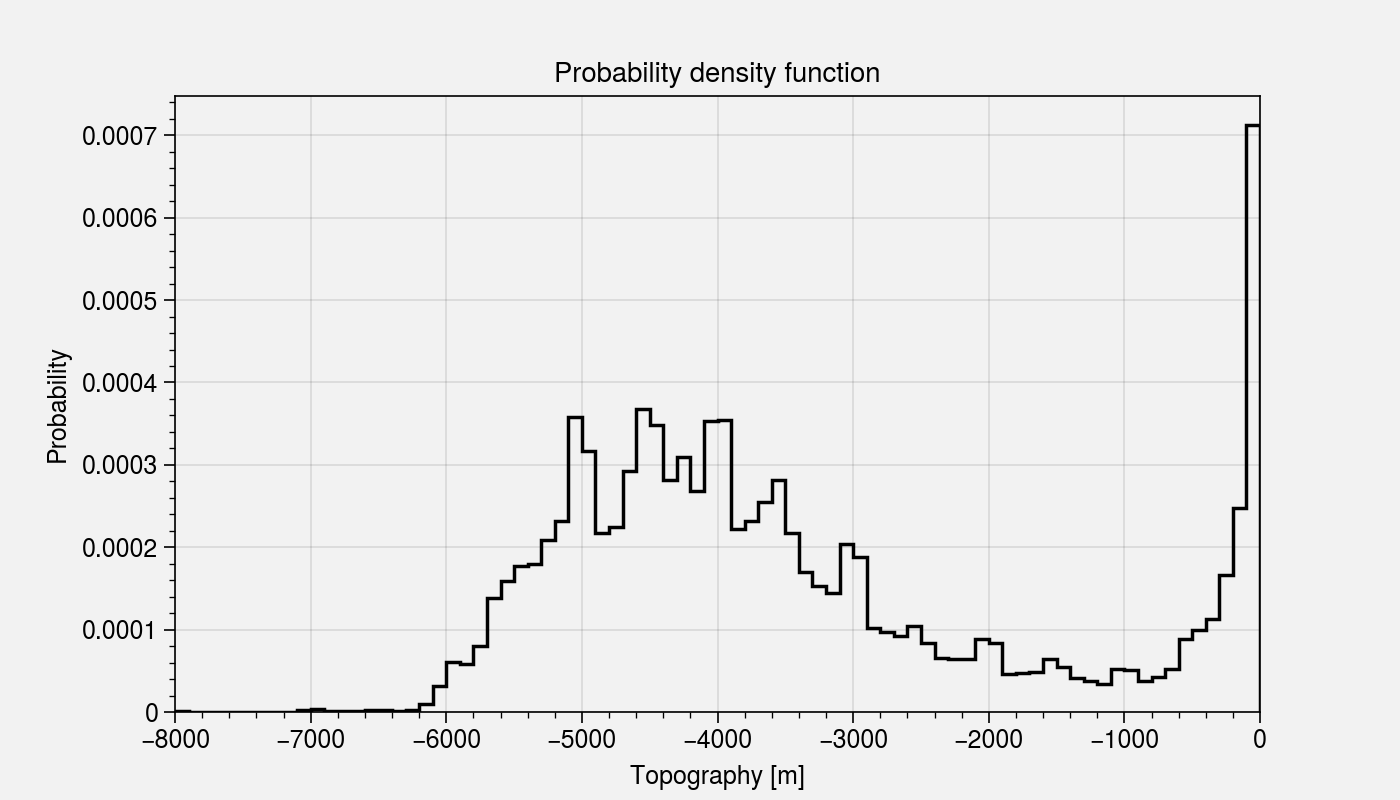

In [7]:
# Histogram o ocean depth
fig, ax = plt.subplots(figsize=(7,4))

binsize = 100

kw = {'bins': np.arange(-8000,200,binsize),
      'histtype':'step',
      'density': True,
      'rwidth': 1,
      'color': 'k',
      'linewidth': 1.25
     }

topo.z.where(topo.z<0).plot.hist(ax,**kw)

ax.set_xlim([-8000,0])
ax.set_title('Probability density function')
ax.set_xlabel('Topography [m]')
ax.set_ylabel('Probability')

plt.savefig('assets/imgs/TopographyPDF.png',
            dpi=400,
            bbox_inches='tight'
           )

In [ ]:
# Histogram o ocean depth
fig, ax = plt.subplots(figsize=(7,4),
                       nrows=1)


kw = {'bins': np.arange(-8000,200,binsize),
      'histtype':'step',
      'density': True,
      'cumulative': True,
      'rwidth': 1,
      'color': 'k',
      'linewidth': 1.25
     }

hist = topo.z.where(topo.z<0).plot.hist(ax,**kw)

ax.set_xlim([-8000,0])
ax.set_title('Cumulative density function')
ax.set_xlabel('Topography [m]')
ax.set_ylabel('Probability')



plt.savefig('assets/imgs/TopographyCDF.png',
            dpi=400,
            bbox_inches='tight'
           )

In [125]:
# Area of continental shelf (z>-200 and z<0)
hist[0][-1]-hist[0][-2]

0.09598708527916577

In [126]:
# Area ocean deeper than 2000 m 
hist[0][30]

0.800913075913418

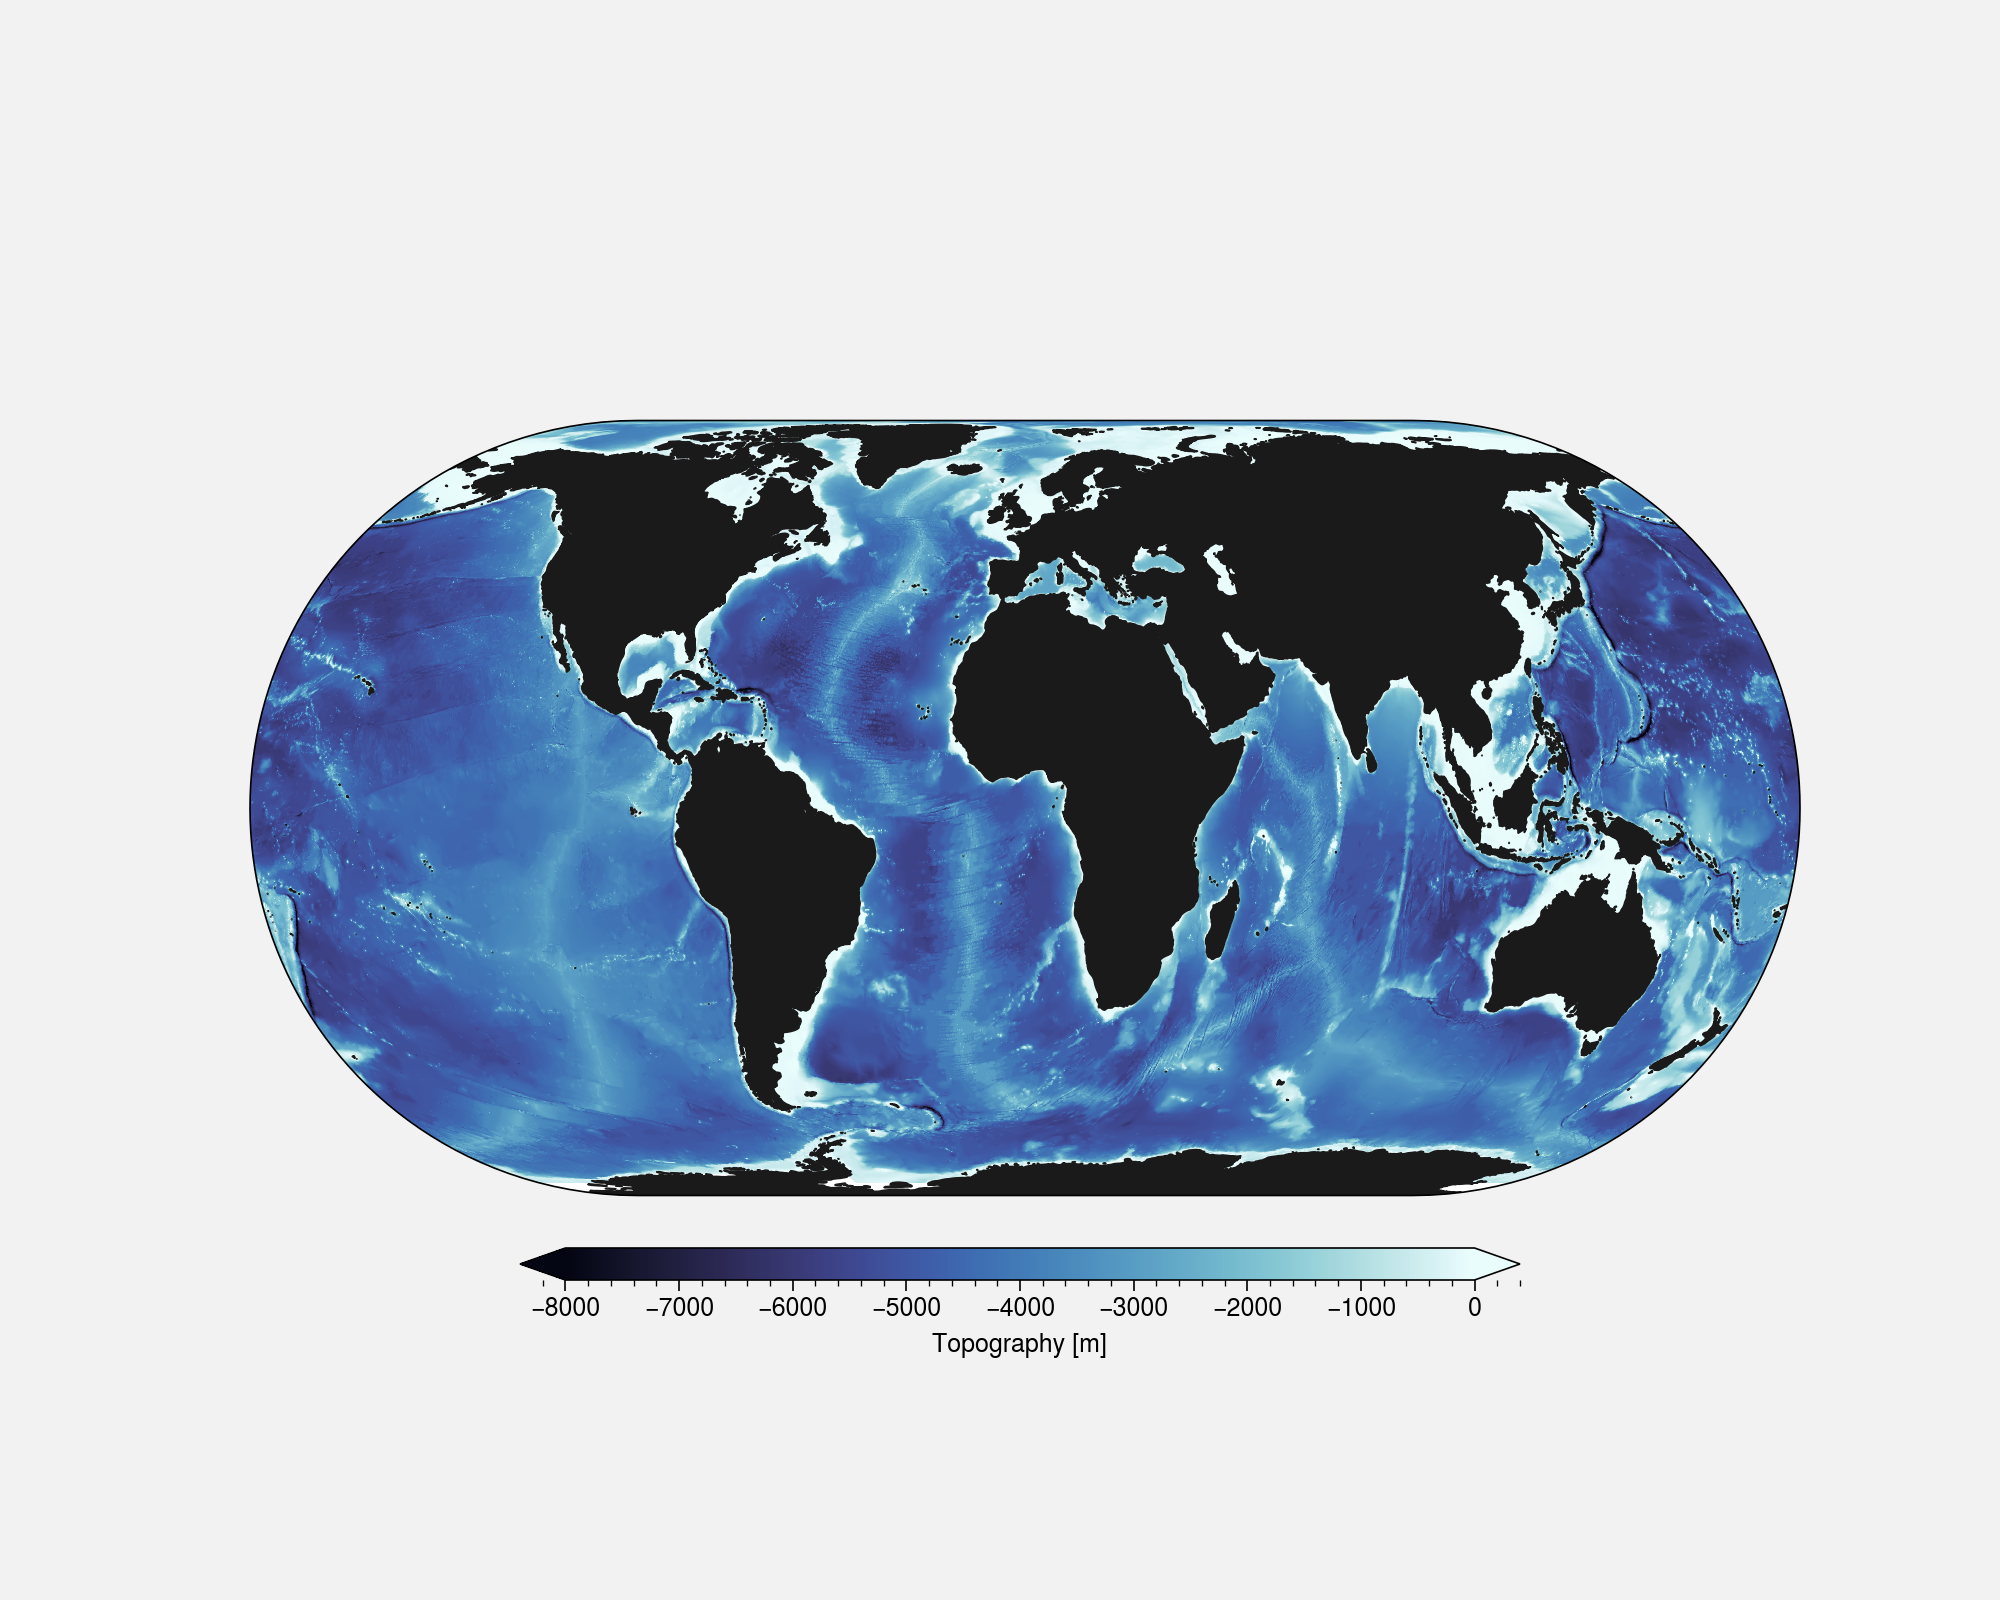

In [11]:
# projection = ccrs.PlateCarree()
projection = ccrs.EckertIV()



axes_class = (GeoAxes,{'map_projection':projection})


fig = plt.figure(figsize=(10,8))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1,1),
                axes_pad=0.1,
                label_mode='')  # note the empty label_mode

ax = axgr[0]

kw = {'ax': ax,
      'add_colorbar': False,
      'cmap': cmocean.cm.ice,
      'vmin':-8000,
      'vmax':0}

ctopo = topo.z.where(topo.z<0).plot.pcolormesh(**kw,transform=ccrs.PlateCarree())
# ctopo = topo.z.where(topo.z<0).plot.pcolormesh(**kw,transform=ccrs.EckertIV())

_ = ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='face', facecolor='0.1')
                  )

# Colorbar
kw = {'ticks': [-8000,-7000,-6000,-5000,-4000,-3000,-2000,-1000,0],
      'extend':'both',
      'label': 'Topography [m]'}

cbar_ax = fig.add_axes([0.26, 0.2, .5, 0.02])
cbar = fig.colorbar(ctopo, cax=cbar_ax, 
            orientation='horizontal',
            **kw
)


# plt.savefig('assets/imgs/Topography.png',
#             dpi=400,
#             bbox_inches='tight'
#            )

Text(0.5, 0, 'Longitude')

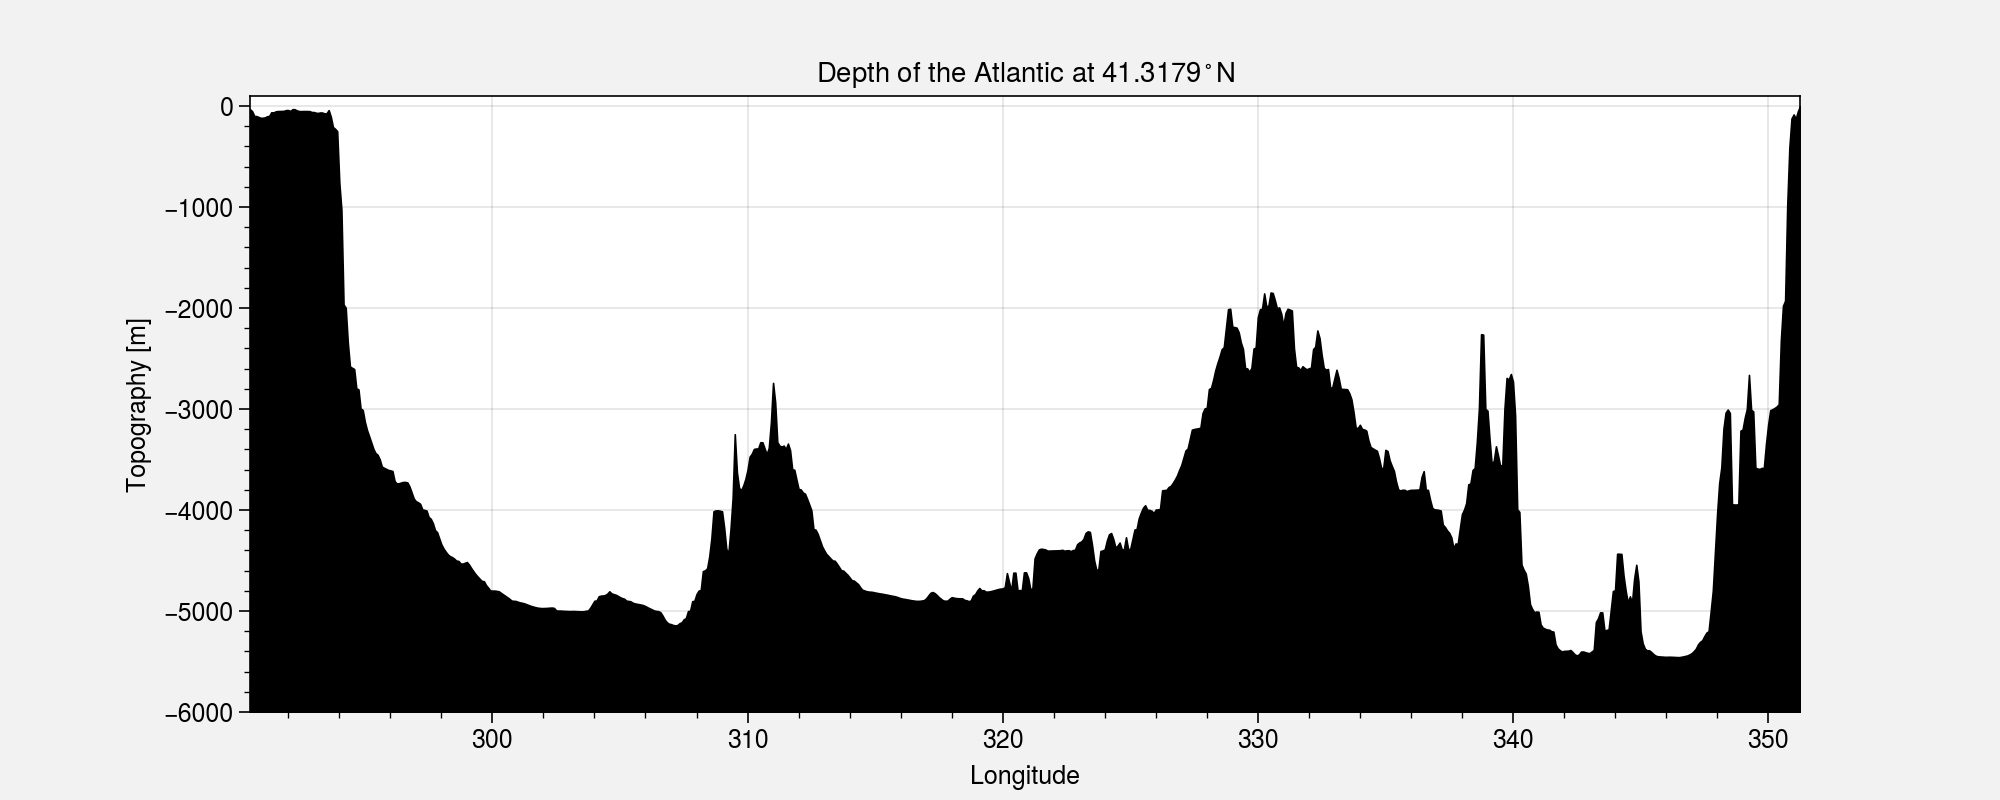

In [15]:
# Topographic section at 41.3179 N
latref = 41.3179

fig, ax = plt.subplots(figsize=(10,4))
toposec = topo.elev_ocean.sel(lat=latref, method='nearest').sel(lon=slice(270,360))
# toposec.plot(ax=ax)
plt.fill_between(toposec.lon,y1=-6000,y2=toposec.values,color='k')

xlim = (290.5,351.25)

plt.ylim(-6000,100)
plt.xlim(*xlim)

ax.set_title(r'Depth of the Atlantic at 41.3179$^\circ$N')
ax.set_ylabel('Topography [m]')
ax.set_xlabel('Longitude')

# plt.savefig('assets/imgs/TopographySection.png',
#             dpi=100,
#             bbox_inches='tight'
#            )

FileNotFoundError: [Errno 2] No such file or directory: 'assets/imgs/TopographyWithLine.png'

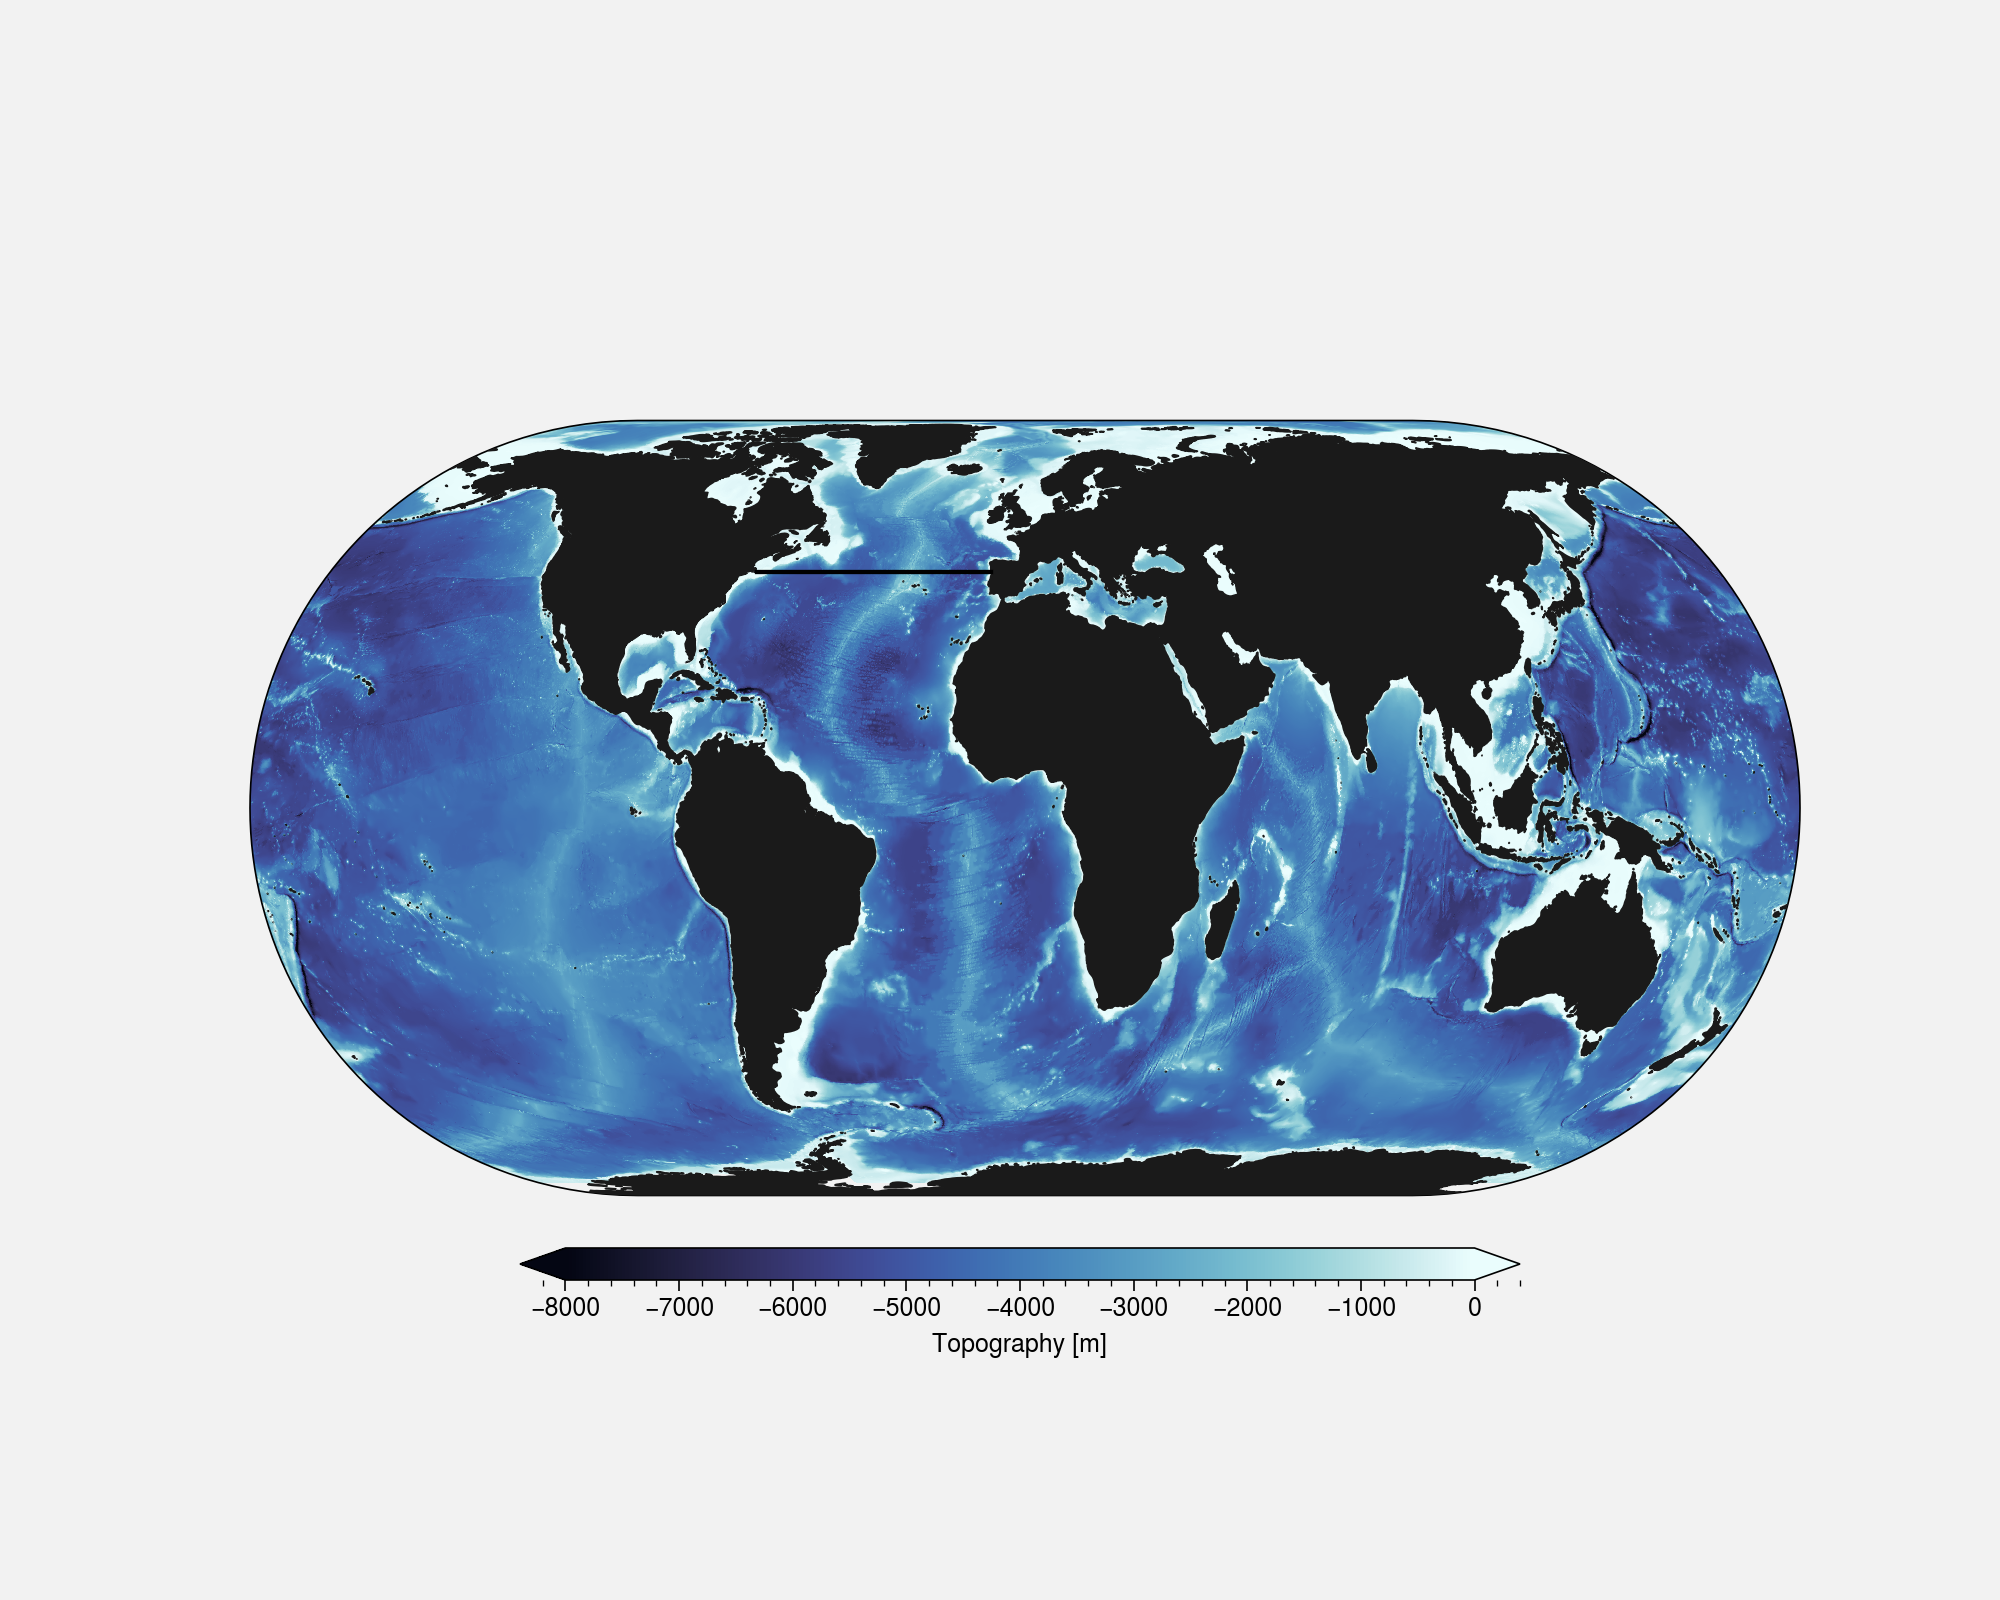

In [16]:
# projection = ccrs.PlateCarree()
axes_class = (GeoAxes,{'map_projection':projection})


fig = plt.figure(figsize=(10,8))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1,1),
                axes_pad=0.1,
                label_mode='')  # note the empty label_mode

ax = axgr[0]

kw = {'ax': ax,
      'add_colorbar': False,
      'cmap': cmocean.cm.ice,
      'vmin':-8000,
      'vmax':0}

ctopo = topo.z.where(topo.z<0).plot.pcolormesh(**kw,transform=ccrs.PlateCarree(),zorder=1)

sec = topo.sel(lat=latref, method='nearest').sel(lon=slice(*xlim))

# ax.plot(sec.lon.values,[latref]*sec.lon.size,color='k',transform=ccrs.PlateCarree(),zorder=10)
ax.plot([xlim[0],xlim[1]],[latref,latref],color='k',transform=ccrs.PlateCarree(),zorder=10)


x = sec.lon.values
y = np.ones_like(x)*latref

# ax.plot([xlim[0],xlim[1]],[latref,latref],color='k',transform=ccrs.PlateCarree(),zorder=10)
ax.plot(x,y,color='k',transform=ccrs.PlateCarree(),zorder=10)


_ = ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='face', facecolor='0.1'),
                                                zorder=7)

# Colorbar
kw = {'ticks': [-8000,-7000,-6000,-5000,-4000,-3000,-2000,-1000,0],
      'extend':'both',
      'label': 'Topography [m]'}

cbar_ax = fig.add_axes([0.26, 0.2, .5, 0.02])
cbar = fig.colorbar(ctopo, cax=cbar_ax, 
            orientation='horizontal',
            **kw
)


projection = ccrs.PlateCarree()
axes_class = (GeoAxes,{'map_projection':projection})


plt.savefig('assets/imgs/TopographyWithLine.png',
            dpi=400,
            bbox_inches='tight'
           )